In [1]:
import pandas as pd
from pathlib import Path
import os
import random
import numpy as np
import json
from datetime import timedelta
from collections import Counter
from tqdm.notebook import tqdm
from heapq import nlargest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# DATA_PATH = Path('.')
TRAIN_PATH = 'train.jsonl'
TEST_PATH = 'test.jsonl'
SAMPLE_SUB_PATH = Path('sample_submission.csv')

In [3]:
with open(TRAIN_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the training data")

We have 12,899,779 lines in the training data


In [4]:
sample_size = 150000

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_train_df = c
    break

In [5]:
sample_train_df

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."
...,...,...
149995,149995,"[{'aid': 443027, 'ts': 1659332465408, 'type': ..."
149996,149996,"[{'aid': 1849006, 'ts': 1659332465484, 'type':..."
149997,149997,"[{'aid': 135905, 'ts': 1659332465575, 'type': ..."
149998,149998,"[{'aid': 288928, 'ts': 1659332465804, 'type': ..."


In [6]:
sample_train_df.set_index('session', drop=True, inplace=True)
sample_train_df.head()

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [7]:
example_session = sample_train_df.iloc[0].item()
print(f'This session was {len(example_session)} actions long \n')
print(f'The first action in the session: \n {example_session[0]} \n')

# Time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
# The timestamp is in milliseconds since 00:00:00 UTC on 1 January 1970
print(f'The first session elapsed: {str(timedelta(milliseconds=time_elapsed))} \n')

# Count the frequency of actions within the session
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1  
print(f'The first session contains the following frequency of actions: {action_counts}')

This session was 276 actions long 

The first action in the session: 
 {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 

The first session elapsed: 27 days, 13:09:43.682000 

The first session contains the following frequency of actions: {'clicks': 255, 'carts': 17, 'orders': 4}


In [8]:
### Extract information from each session and add it to the df ###

action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))
    
sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/150000 [00:00<?, ?it/s]

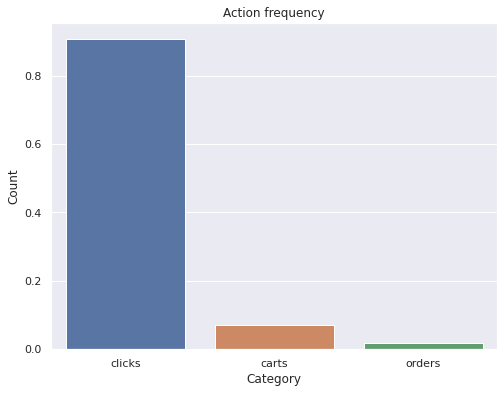

In [9]:
### Actions ###

total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

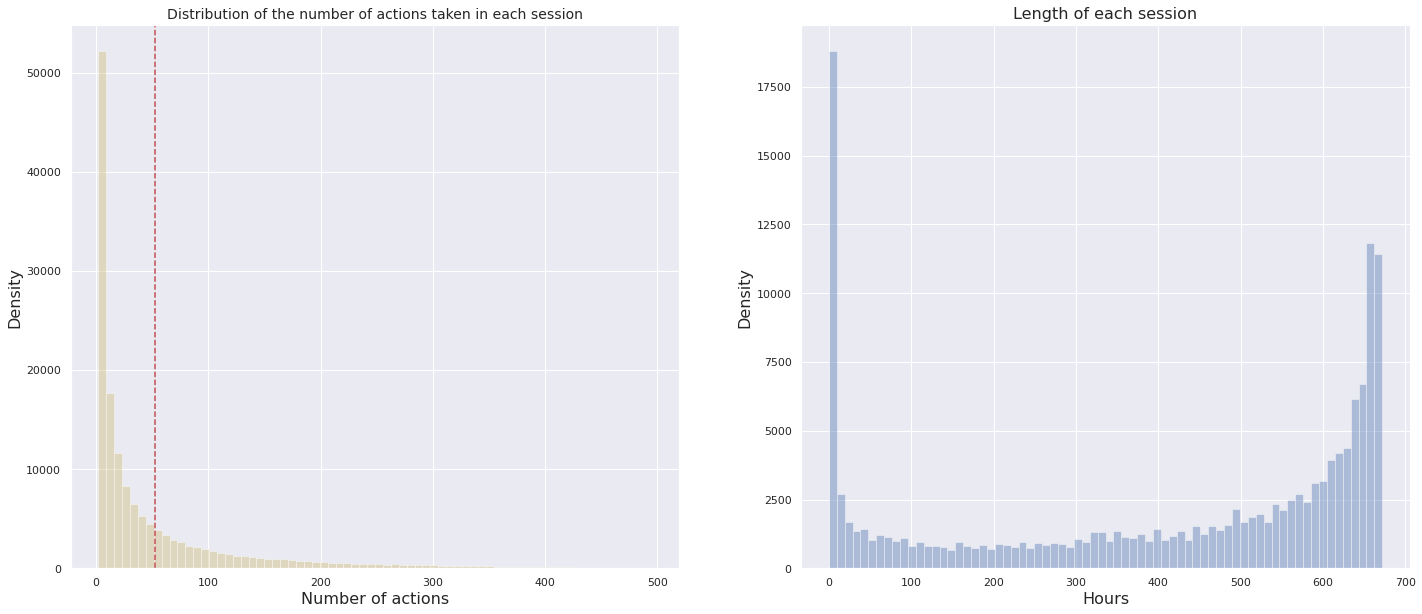

In [10]:
fig, ax = plt.subplots(1,2, figsize=(24, 10))

p = sns.distplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16);

In [11]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"]<10])/len(sample_train_df),3)*100}% of the sessions had less than 10 actions')

34.8% of the sessions had less than 10 actions


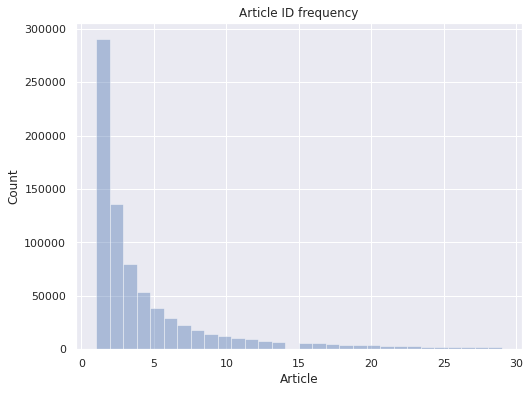

In [12]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

In [13]:
### Look at the most interacted with articles ###
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]


In [14]:
with open(TEST_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the test data")

We have 1,671,803 lines in the test data


In [15]:
sample_size = 150

chunks = pd.read_json(TEST_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_test_df = c
    break

In [16]:
sample_test_df.head()

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [17]:
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)
sample_submission.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


In [22]:
sample_size = 1500

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

clicks_article_list = []
carts_article_list = []
orders_article_list = []

for e, c in tqdm(enumerate(chunks)):
    
    # Save time by not using all the data
    if e > 2000:
        break
    
    sample_train_df = c
    
    for i, row in c.iterrows():
        actions = row['events']
        for action in actions:
            if action['type'] == 'clicks':
                clicks_article_list.append(action['aid'])
            elif action['type'] == 'carts':
                carts_article_list.append(action['aid'])
            else:
                orders_article_list.append(action['aid'])

0it [00:00, ?it/s]

In [23]:
article_click_freq = Counter(clicks_article_list)
article_carts_freq = Counter(carts_article_list)
article_order_freq = Counter(orders_article_list)

In [24]:
top_click_article = nlargest(20, article_click_freq, key = article_click_freq.get)
top_carts_article = nlargest(20, article_carts_freq, key = article_carts_freq.get)
top_order_article = nlargest(20, article_order_freq, key = article_order_freq.get) 

In [25]:
frequent_articles = {'clicks': top_click_article, 'carts':top_carts_article, 'order':top_order_article}

In [26]:
for action in ['clicks', 'carts', 'order']:
    print(f'Most frequent articles for {action}: {frequent_articles[action][-5:]}')

Most frequent articles for clicks: [231487, 332654, 95488, 986164, 670006]
Most frequent articles for carts: [1445562, 1498443, 801774, 986164, 1111967]
Most frequent articles for order: [1025795, 800391, 1111967, 527209, 29735]


In [ ]:
test_data = pd.read_json(TEST_PATH, lines=True, chunksize=1000)

preds = []

for chunk in tqdm(test_data, total=1671):
    
    for i, row in chunk.iterrows():
        actions = row['events']
        article_id_list = []
        for action in actions:
            article_id_list.append(action['aid'])
            
        # Get 20 most common article ID for the session
        article_freq = Counter(article_id_list)
        top_articles = nlargest(20, article_freq, key = article_freq.get)
        
        # Pad with most popular items in training
        padding_size = -(20 - len(top_articles))
        for action in ['clicks', 'carts', 'order']:
            top_articles = top_articles + frequent_articles[action][padding_size:]
            preds.append(" ".join([str(id) for id in top_articles]))

  0%|          | 0/1671 [00:00<?, ?it/s]